### Example of Interpolating Fields on a Volume Mesh
We have solution points on a volume mesh, but we need the solution at "n integration points" between each node pairing on a thickness, so we need to do interpolation of the volume mesh. If we collect all of these "n integrtion points" bewtween each pairing of nodes, this simply gives us an array of locations to interpolating a known solution to

In [9]:
from lib.scl import SCL
import pandas as pd
from lib.vinterp import interpolate_nodal_values
from pathlib import WindowsPath 
import numpy as np

N_INTEGRATION_POINTS = 47                       #the number of integration points, this is the default in APDL's equivalent function
DPATH = WindowsPath('data')
TOP_SURFACE_NODE_FILE = 'ts.node.loc'           #the nodes on the top surface, 3D locations indexed on node tag
BOTTOM_SURFACE_NODE_FILE = 'bs.node.loc'        #the nodes on the bottom surface
NODE_LOCATION_FILE = 'pb.node.loc'              #the location of nodes in the volume mesh
STRESS_DATA_FILE = 'pb.node.dat'                #the stress field at the nodes on the volume mesh

#read in the node files
top_surface_nodes = pd.read_csv(DPATH.joinpath(TOP_SURFACE_NODE_FILE),index_col = 0,header = None)
top_surface_nodes.index = top_surface_nodes.index.astype(int)

bottom_surface_nodes = pd.read_csv(DPATH.joinpath(BOTTOM_SURFACE_NODE_FILE),index_col = 0,header = None)
bottom_surface_nodes.index = bottom_surface_nodes.index.astype(int)

#get paired nodes from other example
paired_loc = np.load(str(DPATH.joinpath('paired.npy')))
loc1 = top_surface_nodes.loc[paired_loc[:,0]]
loc2 = bottom_surface_nodes.loc[paired_loc[:,1]]

#Make integration points to interpolate too
scl_apdl = SCL(loc1.to_numpy(),loc2.to_numpy())
scl_points = scl_apdl(N_INTEGRATION_POINTS,flattened = True)

node_loc = pd.read_csv(DPATH.joinpath(NODE_LOCATION_FILE),index_col = 0,header = None)
node_sol = pd.read_csv(DPATH.joinpath(STRESS_DATA_FILE),index_col = 0,header = None)

node_loc = node_loc.loc[node_sol.index]

scl_stress = interpolate_nodal_values(node_loc.to_numpy(),
                                    node_sol.to_numpy(),
                                    scl_points)

np.save(DPATH.joinpath('pb.interp.sol'),scl_stress)
np.save(DPATH.joinpath('pb.interp.loc'),scl_points)
print('Number of Points in Original Mesh: {}'.format(node_sol.shape))
print('Number of Interpolant Points: {}'.format(scl_stress.shape))

Number of Points in Original Mesh: (16605, 6)
Number of Interpolant Points: (256056, 6)


### Visualization

We are just making points on the purple mesh down below to interpolate values from the FEM mesh in APDL (blue points) too. 

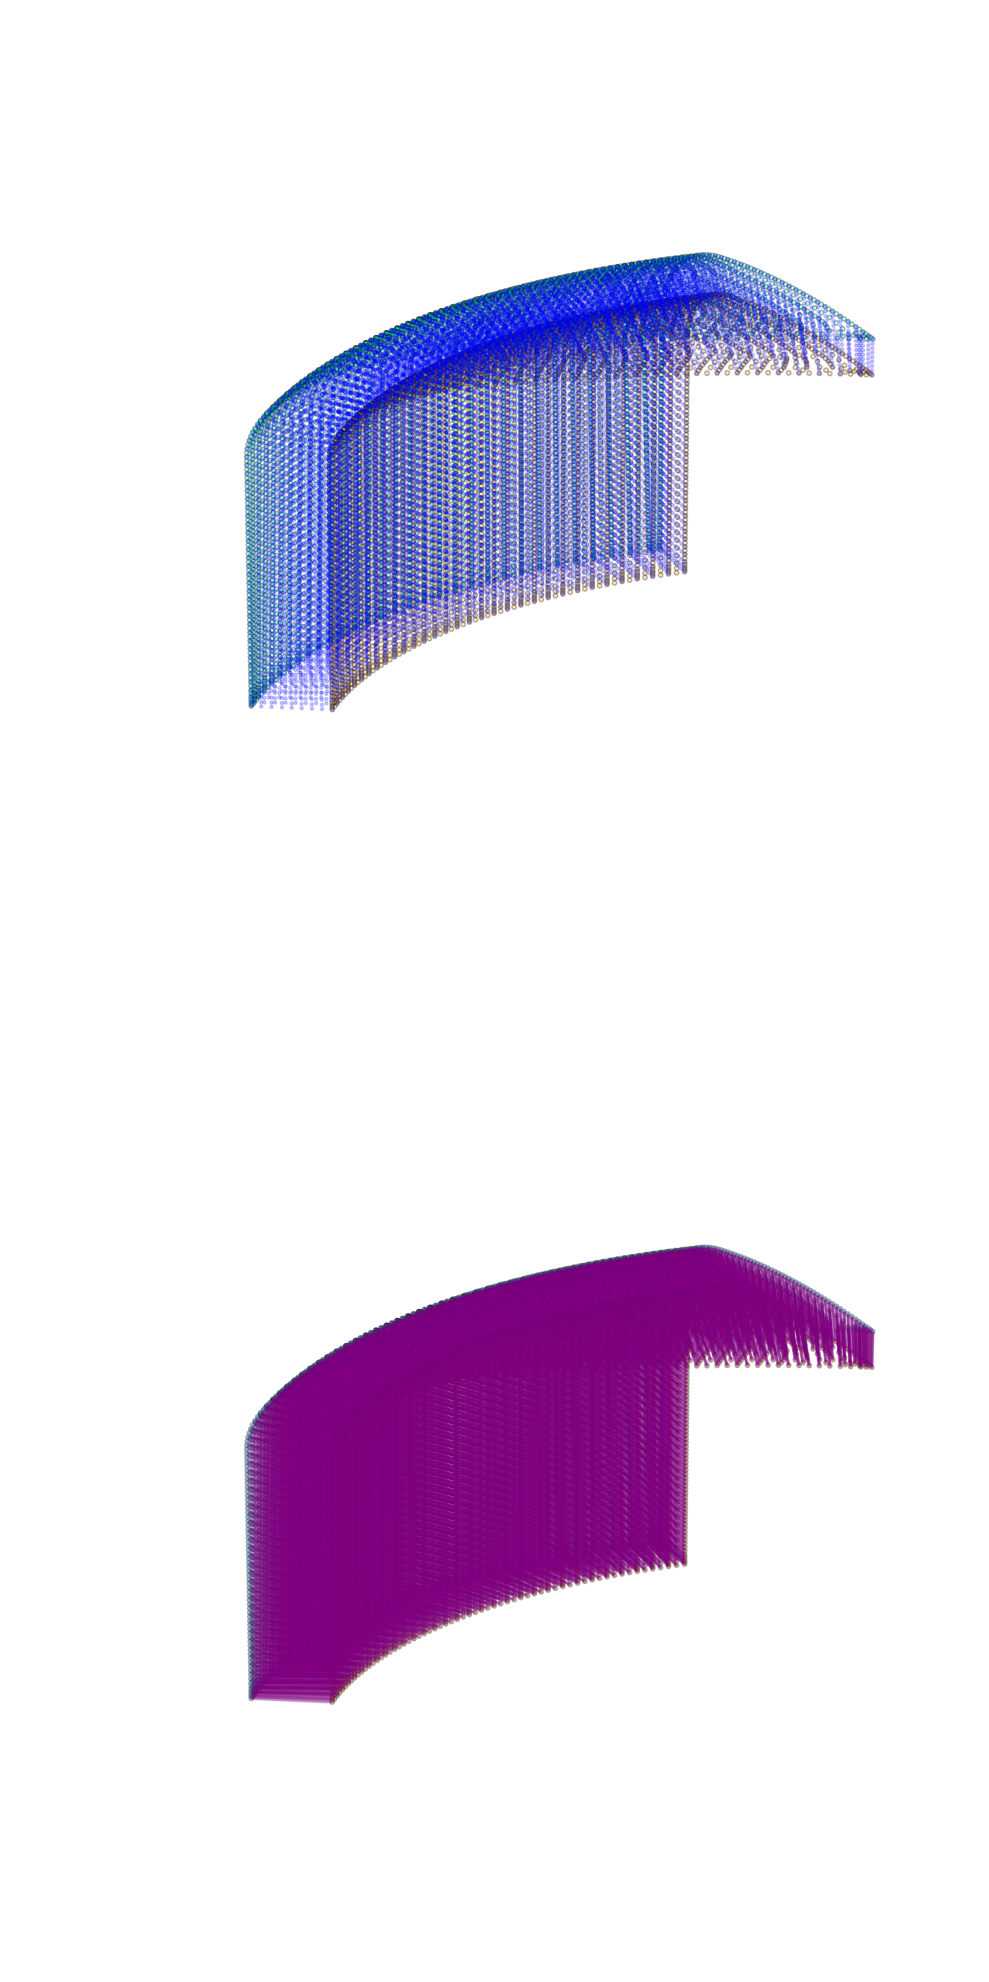

In [6]:
from matplotlib import pyplot as plt 

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(2,1,1,projection = '3d')
ax2 = fig.add_subplot(2,1,2,projection = '3d')

for ax,points,sz,color in zip([ax1,ax2],[node_loc.to_numpy(), scl_points],[5,2.5],['blue','purple']):

    ax.scatter(*[loc1.to_numpy()[:,i] for i in range(3)],edgecolor = 'k',facecolor = 'cyan', s = 10,alpha = 0.3)
    ax.scatter(*[loc2.to_numpy()[:,i] for i in range(3)],edgecolor = 'k',facecolor = 'orange', s = 10,alpha = 0.3)
    ax.scatter(*[points[:,i] for i in range(3)],facecolor = color,s = sz,alpha = 0.2)
    ax.view_init(elev = 20,azim = 160)

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.set_axis_off()

fig.tight_layout()